# NBA Player Analysis: Are the type of players changing?

# Imports

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Building
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Resources

Data:

https://www.kaggle.com/abhinavp23/nba-stats-player-and-team

Other Projects:

https://randerson112358.medium.com/nba-data-analysis-exploration-9293f311e0e8

https://dribbleanalytics.blog/2019/04/positional-clustering/

http://suruchifialoke.com/2017-06-01-clustering-nba-players/

https://www.kaggle.com/terrycheng/nba-players-clustering-using-pca-and-kmeans

Model Resources:

https://365datascience.com/pca-k-means/

Rule Changes:

https://cdn.nba.net/nba-drupal-prod/nba-rules-changes-history.pdf

Possible Stats Additions:

https://bleacherreport.com/articles/1039116-understanding-the-nba-explaining-advanced-offensive-stats-and-metrics

# Load Data

In [225]:
data = pd.read_csv('../data/NBA_Season_Stats.csv')

In [226]:
data.shape

(27943, 31)

In [227]:
data.sort_values('Year', inplace=True)

# Clean Data

In [228]:
# Removes second index column.
data.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [229]:
# Removes rows with null values.
data.dropna(axis=0, inplace=True)

In [230]:
data.shape

(17363, 30)

In [231]:
# Strips * from names and records each player that was in the Hall of Fame as 1 and 0 otherwise.
players = []
hf = []

for player_name in data['Player']:
    if player_name.endswith('*'):
        players.append(player_name.strip('*'))
        hf.append(1)
    else:
        players.append(player_name)
        hf.append(0)

In [232]:
# Replaces column, Player, with stripped names.
# Adds column, HF, to indicate whether or not a player was inducted into the Hall of Fame
data['Player'] = players
data['HF'] = hf

In [233]:
data.columns

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'HF'],
      dtype='object')

In [234]:
# Sums up player's season stats if they were traded within a season.
players = data.groupby(['Year', 'Player', 'Pos'])[['G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']].sum().reset_index()

In [235]:
# Adds the column, HF.
# Don't know if I need this because players can't be voted into the HF until after they retire. 2000-2019 are going to have less.
players['HF'] = data.groupby(['Year', 'Player', 'Pos'])['HF'].max().reset_index()['HF']

In [236]:
# Recalculates the percentage columns.
players['FG%'] = players['FG']/players['FGA']
players['FT%'] = players['FT']/players['FTA']
players['3P%'] = players['3P']/players['3PA']
players['2P%'] = players['2P']/players['2PA']
players['eFG%'] = (players['FG'] + 0.5*players['3P'])/players['FGA']

In [237]:
# Changes the year column to an integer
players['Year'] = players['Year'].astype(int)

In [238]:
# Transforms categorical column, Pos, into dummy variables.
players_w_dum = pd.get_dummies(players, columns=['Pos'])
players_w_dum['Pos'] = players['Pos']

In [239]:
# Shape of new dataframe.
players_w_dum.shape

(13724, 45)

In [240]:
# Drops Players with 0 turnovers.
players = players[players['TOV']!=0]

In [241]:
# Drops players who have 100% accuracy for shooting.
players_w_dum = players_w_dum[players_w_dum['3P%']<1]
players_w_dum = players_w_dum[players_w_dum['2P%']<1]
players_w_dum = players_w_dum[players_w_dum['FT%']<1]
players_w_dum = players_w_dum[players_w_dum['eFG%']<1]

In [242]:
# Drops any leftover null values.
players_w_dum.dropna(axis=0, inplace=True)

In [245]:
# Splits data on 1999 where the five second rule was implemented.
# Five second rule makes the game go faster forcing players to make decisions faster.
pre_rule = players_w_dum[players_w_dum['Year']<=1999]
post_rule = players_w_dum[players_w_dum['Year']>1999]

In [246]:
pre_rule.shape

(5441, 45)

In [247]:
post_rule.shape

(7857, 45)

# EDA

In [248]:
players_w_dum.columns

Index(['Year', 'Player', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'HF', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF', 'Pos'],
      dtype='object')

In [249]:
pos_pre = pre_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]
pos_post = post_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

In [250]:
main_pre = pos_pre[['Pos_C', 'Pos_PF', 'Pos_SF', 'Pos_SG', 'Pos_PG']]
main_post = pos_post[['Pos_C', 'Pos_PF', 'Pos_SF', 'Pos_SG', 'Pos_PG']]

other_pre = pos_pre[['Pos_C-PF', 'Pos_C-SF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG-SF', 
                     'Pos_PG-SG', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]
other_post = pos_post[['Pos_C-PF', 'Pos_C-SF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG-SF', 
                     'Pos_PG-SG', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

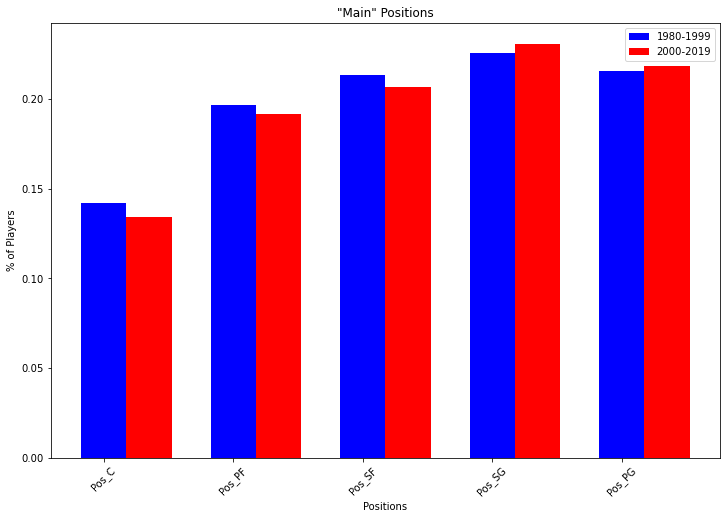

In [675]:
pos = 5
idx = np.arange(pos)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(idx, main_pre.sum()/main_pre.shape[0], width, color='blue', label='1980-1999')
ax.bar(idx+width, main_post.sum()/main_post.shape[0], width, color='red', label='2000-2019')

ax.set_title('"Main" Positions')
ax.set_xlabel('Positions')
ax.set_ylabel('% of Players')
ax.set_xticks(idx)
ax.set_xticklabels(main_pre.columns, rotation=45)

ax.legend();

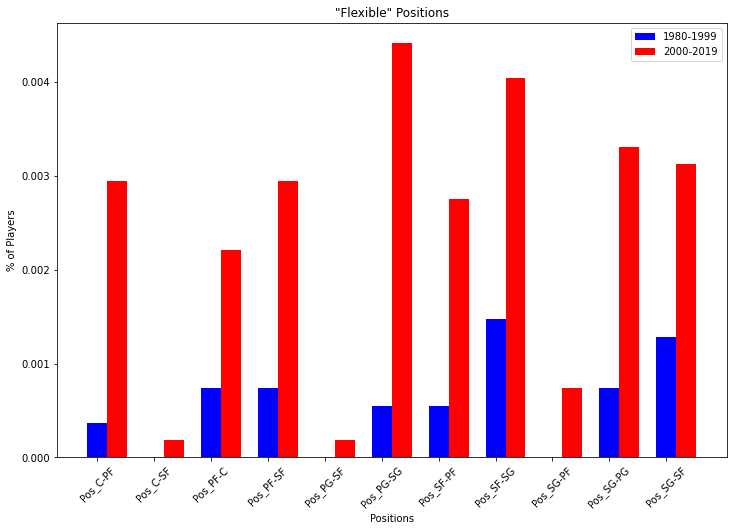

In [674]:
pos = 11
idx = np.arange(pos)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(idx, other_pre.sum()/other_pre.shape[0], width, color='blue', label='1980-1999')
ax.bar(idx+width, other_post.sum()/other_pre.shape[0], width, color='red', label='2000-2019')

ax.set_title('"Flexible" Positions')
ax.set_xlabel('Positions')
ax.set_ylabel('% of Players')
ax.set_xticks(idx)
ax.set_xticklabels(other_pre.columns, rotation=45)

ax.legend();

__C__: Center, 5 (ie. Shaquille O'Neal)

__PF__: Power Foward, 4 (ie. Chris Bosh)

__SF__: Small Foward, 3 (ie. Kawhi Leonard)

__SG__: Shooting Guard, 2 (ie. Klay Thompson)

__PG__: Point Guard, 1 (ie. Stephen Curry)

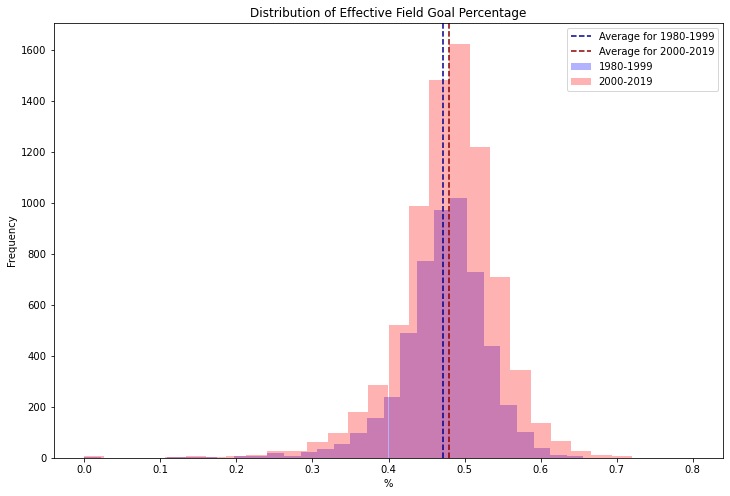

In [673]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(pre_rule['eFG%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['eFG%'], bins=30, color='red', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['eFG%'].mean(), color='darkblue', linestyle='dashed', label='Average for 1980-1999')
ax.axvline(post_rule['eFG%'].mean(), color='darkred', linestyle='dashed', label='Average for 2000-2019')

ax.set_title('Distribution of Effective Field Goal Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

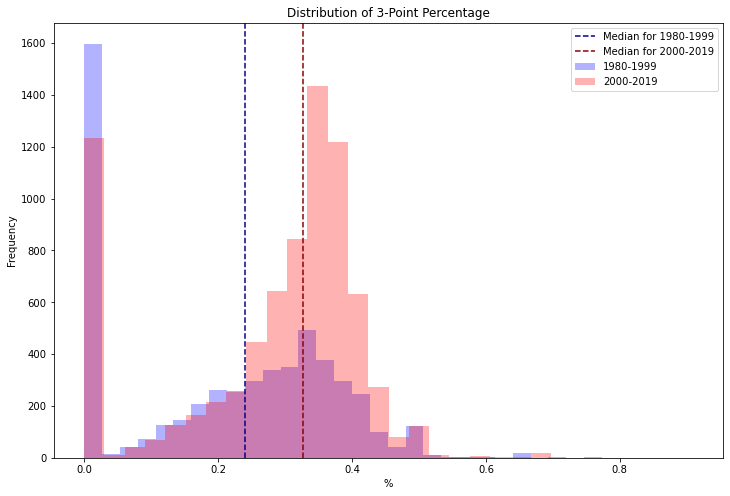

In [672]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(pre_rule['3P%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['3P%'], bins=30, color='red', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['3P%'].median(), color='darkblue', linestyle='dashed', label='Median for 1980-1999')
ax.axvline(post_rule['3P%'].median(), color='darkred', linestyle='dashed', label='Median for 2000-2019')

ax.set_title('Distribution of 3-Point Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

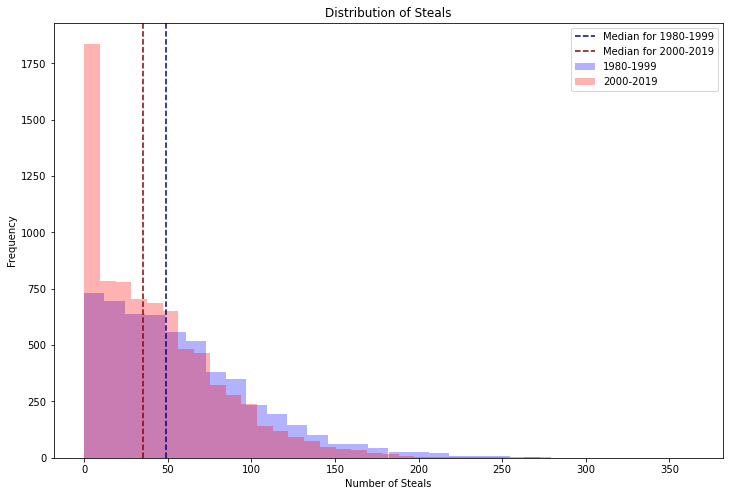

In [671]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(pre_rule['STL'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['STL'], bins=30, color='red', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['STL'].median(), color='darkblue', linestyle='dashed', label='Median for 1980-1999')
ax.axvline(post_rule['STL'].median(), color='darkred', linestyle='dashed', label='Median for 2000-2019')

ax.set_title('Distribution of Steals')
ax.set_xlabel('Number of Steals')
ax.set_ylabel('Frequency')

ax.legend();

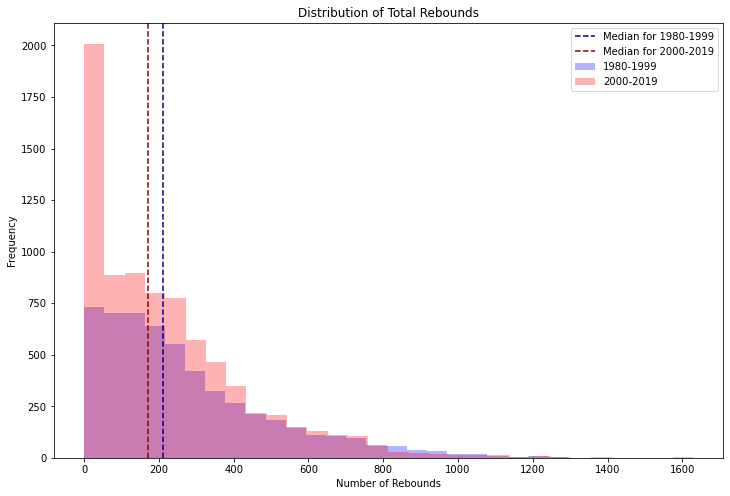

In [670]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(pre_rule['TRB'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['TRB'], bins=30, color='red', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['TRB'].median(), color='darkblue', linestyle='dashed', label='Median for 1980-1999')
ax.axvline(post_rule['TRB'].median(), color='darkred', linestyle='dashed', label='Median for 2000-2019')

ax.set_title('Distribution of Total Rebounds')
ax.set_xlabel('Number of Rebounds')
ax.set_ylabel('Frequency')

ax.legend();

# Build Model

## PCA

In [734]:
X_pre = np.array(pre_rule[['FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 'eFG%', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']])
X_post = np.array(post_rule[['FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 'eFG%', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']])

In [735]:
X_pre.shape

(5441, 34)

In [736]:
X_post.shape

(7857, 34)

In [737]:
# Scales data.
scaled_pre = StandardScaler().fit_transform(X_pre)
scaled_post = StandardScaler().fit_transform(X_post)

In [738]:
# Initializes and fits PCA's.
pca_pre = PCA().fit(scaled_pre)
pca_post = PCA().fit(scaled_post)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


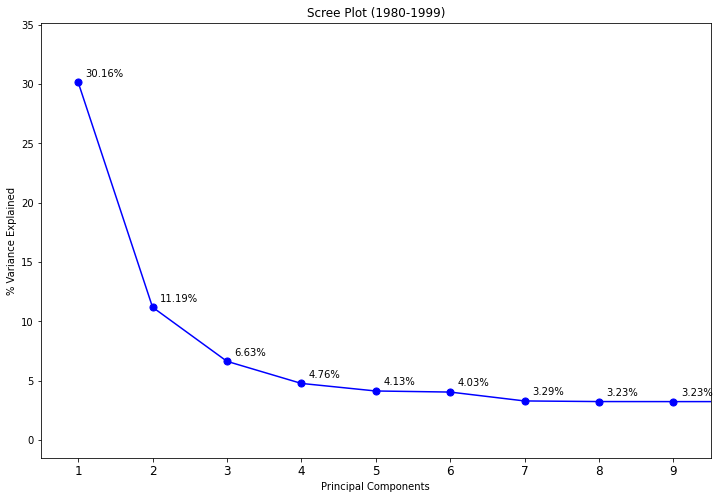

In [739]:
fig, ax = plt.subplots(figsize=(12, 8))

num_components = pca_pre.n_components_
idx = np.arange(num_components)
vals = pca_pre.explained_variance_ratio_*100

ax.plot(idx, vals, color='blue')
ax.scatter(idx, vals, color='blue', s=50)

for i in range(9):
    ax.annotate(r"{:2.2f}%".format(vals[i]), (idx[i]+0.1, vals[i]+0.5))

ax.set_title('Scree Plot (1980-1999)')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')

ax.set_xticklabels(idx+1, fontsize=12)
ax.set_xticks(np.arange(9))
ax.set_xlim(left=0-0.5, right=8+0.5)
ax.set_ylim(top=max(vals)+5);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


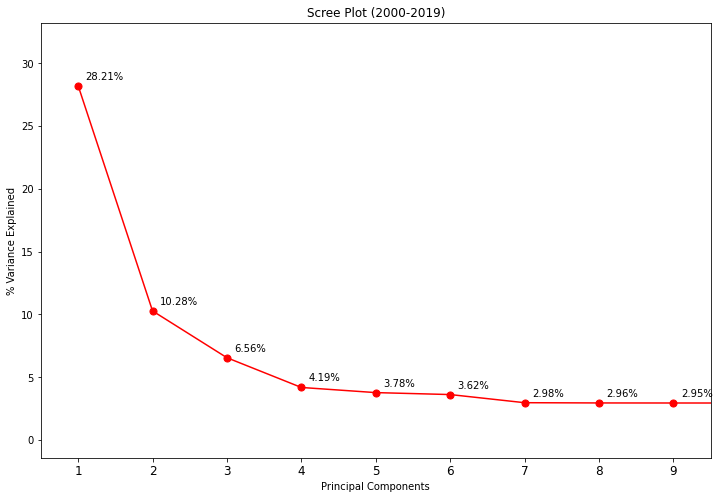

In [740]:
fig, ax = plt.subplots(figsize=(12, 8))

num_components = pca_post.n_components_
idx = np.arange(num_components)
vals = pca_post.explained_variance_ratio_*100

ax.plot(idx, vals, color='red')
ax.scatter(idx, vals, color='red', s=50)

for i in range(9):
    ax.annotate(r"{:2.2f}%".format(vals[i]), (idx[i]+0.1, vals[i]+0.5))

ax.set_title('Scree Plot (2000-2019)')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')

ax.set_xticklabels(idx+1, fontsize=12)
ax.set_xticks(np.arange(9))
ax.set_xlim(left=0-0.5, right=8+0.5)
ax.set_ylim(top=max(vals)+5);

In [741]:
# Creates two PCA models with only two the first two principal components.
pre_2_comp = PCA(n_components=2).fit_transform(scaled_pre)
post_2_comp = PCA(n_components=2).fit_transform(scaled_post)

In [743]:
# Changes PC arrays into dataframes.
df_pre = pd.DataFrame(pre_3_comp, columns=['PC1', 'PC2', 'PC3'])

df_post = pd.DataFrame(post_3_comp, columns=['PC1', 'PC2', 'PC3'])

## Hierachial Clustering

In [747]:
sc_pre = []
for k in range(2, 11):
    ha = AgglomerativeClustering(n_clusters=k, linkage='complete').fit(pre_2_comp)
    score = silhouette_score(pre_2_comp, ha.labels_)
    sc_pre.append(score)

In [748]:
sc_post = []
for k in range(2, 11):
    ha = AgglomerativeClustering(n_clusters=k, linkage='complete').fit(post_2_comp)
    score = silhouette_score(post_2_comp, ha.labels_)
    sc_post.append(score)

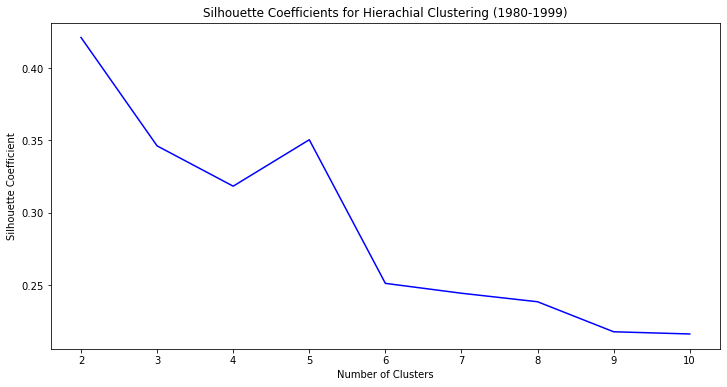

In [749]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(2, 11), sc_pre, color='blue')

ax.set_title('Silhouette Coefficients for Hierachial Clustering (1980-1999)')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Coefficient');

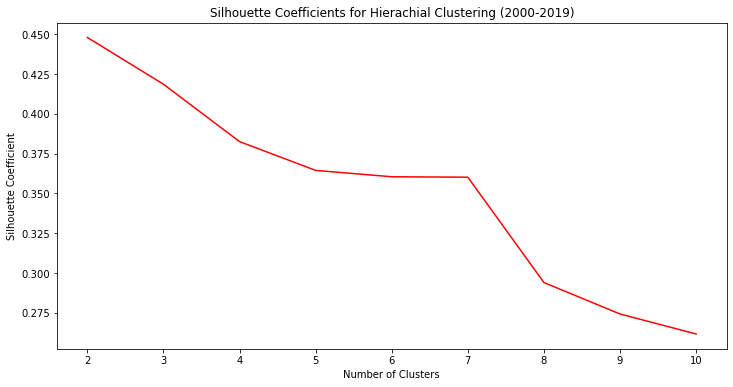

In [750]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(2, 11), sc_post, color='red')

ax.set_title('Silhouette Coefficients for Hierachial Clustering (2000-2019)')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Coefficient');

In [751]:
# Initializes and fits using the Hiearachial Clustering model.
ha_pre = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(pre_2_comp)
ha_post = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(post_2_comp)

In [752]:
# Adds cluster labels and player names to PC's.
cluster_labels_pre = ha_pre.labels_
ha_df_pre = df_pre.copy()
ha_df_pre['Cluster'] = cluster_labels_pre
ha_df_pre['Player'] = np.array(pre_rule['Player'])

cluster_labels_post = ha_post.labels_
ha_df_post = df_post.copy()
ha_df_post['Cluster'] = cluster_labels_post
ha_df_post['Player'] = np.array(post_rule['Player'])

In [753]:
# Calculates cluster proportions.
cluster_0_pre = 1 - ((ha_df_pre['Cluster'].sum())/ha_df_pre.shape[0])
cluster_1_pre = ((ha_df_pre['Cluster'].sum())/ha_df_pre.shape[0])

cluster_0_pre, cluster_1_pre

(0.9057158610549532, 0.09428413894504686)

In [754]:
# Calculates cluster proportions.
cluster_0_post = 1 - ((ha_df_post['Cluster'].sum())/ha_df_post.shape[0])
cluster_1_post = ((ha_df_post['Cluster'].sum())/ha_df_post.shape[0])

cluster_0_post, cluster_1_post

(0.13936617029400533, 0.8606338297059947)

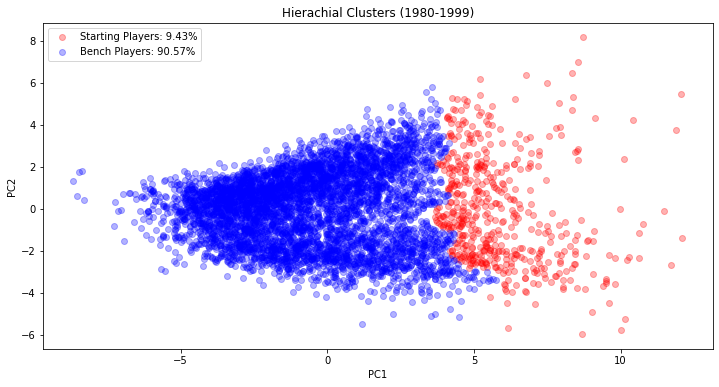

In [769]:
x_1 = ha_df_pre[ha_df_pre['Cluster']==0][['PC1', 'PC2']]
x_2 = ha_df_pre[ha_df_pre['Cluster']==1][['PC1', 'PC2']]

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(x_2['PC1'], x_2['PC2'], color='red', alpha=0.3, label=f'Starting Players: {round(cluster_1_pre*100, 2)}%')
ax.scatter(x_1['PC1'], x_1['PC2'], color='blue', alpha=0.3, label=f'Bench Players: {round(cluster_0_pre*100, 2)}%')

ax.set_title('Hierachial Clusters (1980-1999)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.legend();

In [766]:
check_cluster_pre = pre_rule.copy()
check_cluster_pre['Cluster'] = cluster_labels_pre

check_cluster_pre.groupby('Cluster')[['G', 'GS', 'MP']].median()

,G,GS,MP
Cluster,,,
0,70.0,15.0,1430.5
1,82.0,80.0,2995.0


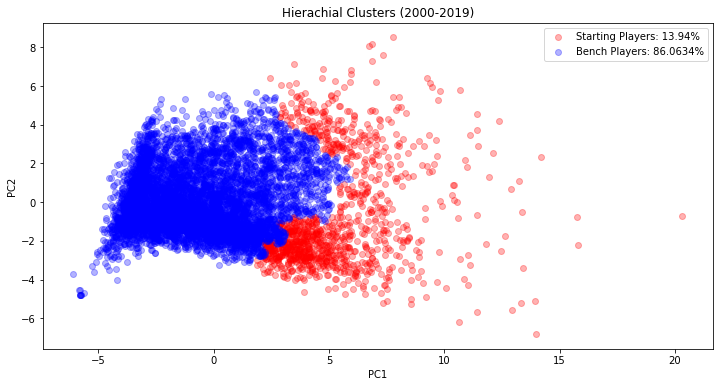

In [767]:
x_1 = ha_df_post[ha_df_post['Cluster']==0][['PC1', 'PC2']]
x_2 = ha_df_post[ha_df_post['Cluster']==1][['PC1', 'PC2']]

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(x_1['PC1'], x_1['PC2'], color='red', alpha=0.3, label=f'Starting Players: {round(cluster_0_post*100, 2)}%')
ax.scatter(x_2['PC1'], x_2['PC2'], color='blue', alpha=0.3, label=f'Bench Players: {round(cluster_1_post*100, 4)}%')

ax.set_title('Hierachial Clusters (2000-2019)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.legend();

In [758]:
check_cluster_post = post_rule.copy()
check_cluster_post['Cluster'] = cluster_labels_post

check_cluster_post.groupby('Cluster')[['G', 'GS', 'MP']].median()

,G,GS,MP
Cluster,,,
0,81.0,79.0,2835.00
1,66.0,12.0,996.45


### PC2 vs. PC3

In [770]:
# Creates two PCA models with only three the first three principal components.
pre_3_comp = PCA(n_components=3).fit_transform(scaled_pre)
post_3_comp = PCA(n_components=3).fit_transform(scaled_post)

In [771]:
# Initializes and fits using the Hiearachial Clustering model.
ha_pre = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(pre_3_comp)
ha_post = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(post_3_comp)

In [772]:
# Adds cluster labels and player names to PC's.
cluster_labels = ha_pre.labels_
ha_df_pre = df_pre.copy()
ha_df_pre['Cluster'] = cluster_labels
ha_df_pre['Player'] = np.array(pre_rule['Player'])

cluster_labels = ha_post.labels_
ha_df_post = df_post.copy()
ha_df_post['Cluster'] = cluster_labels
ha_df_post['Player'] = np.array(post_rule['Player'])

In [773]:
# Calculates cluster proportions.
cluster_0_pre = 1 - ((ha_df_pre['Cluster'].sum())/ha_df_pre.shape[0])
cluster_1_pre = ((ha_df_pre['Cluster'].sum())/ha_df_pre.shape[0])

cluster_0_post = 1 - ((ha_df_post['Cluster'].sum())/ha_df_post.shape[0])
cluster_1_post = ((ha_df_post['Cluster'].sum())/ha_df_post.shape[0])

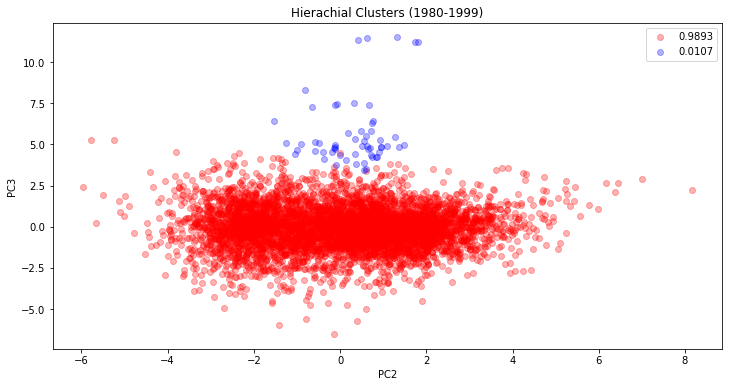

In [778]:
x_1 = ha_df_pre[ha_df_pre['Cluster']==0][['PC2', 'PC3']]
x_2 = ha_df_pre[ha_df_pre['Cluster']==1][['PC2', 'PC3']]

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(x_1['PC2'], x_1['PC3'], color='red', alpha=0.3, label=round(cluster_0_pre, 4))
ax.scatter(x_2['PC2'], x_2['PC3'], color='blue', alpha=0.3, label=round(cluster_1_pre, 4))

ax.set_title('Hierachial Clusters (1980-1999)')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')

ax.legend();

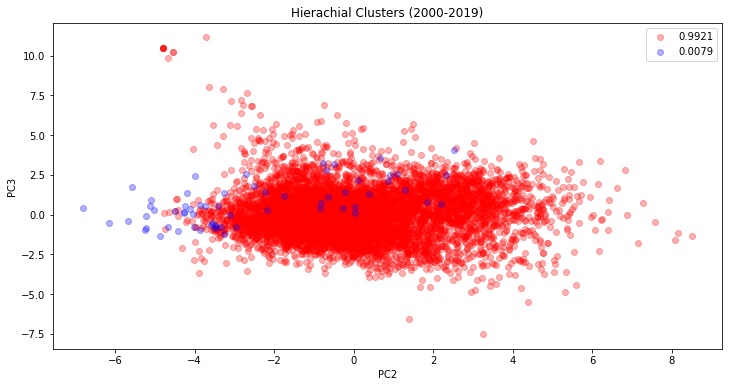

In [777]:
x_1 = ha_df_post[ha_df_post['Cluster']==0][['PC2', 'PC3']]
x_2 = ha_df_post[ha_df_post['Cluster']==1][['PC2', 'PC3']]

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(x_1['PC2'], x_1['PC3'], color='red', alpha=0.3, label=round(cluster_0_post, 4))
ax.scatter(x_2['PC2'], x_2['PC3'], color='blue', alpha=0.3, label=round(cluster_1_post, 4))

ax.set_title('Hierachial Clusters (2000-2019)')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')

ax.legend();

In [570]:
ha_df_post[(ha_df_post['PC2']<-6) | (ha_df_post['PC2']>7)]

,PC1,PC2,PC3,Pos,Cluster,Player
1707,13.962490,-6.811140,0.419929,PG,1,Stephon Marbury
3333,10.649814,-6.167898,-0.519048,PG,1,Chauncey Billups
4129,3.473025,7.151349,-1.805737,C,0,DeAndre Jordan
5230,6.874009,7.282262,0.737020,C,0,Andre Drummond
5702,7.756312,8.503775,-1.371517,C,0,DeAndre Jordan
6151,6.861642,8.166224,-1.166321,C,0,DeAndre Jordan
6588,6.750664,8.073146,-1.598522,C,0,DeAndre Jordan
6884,7.329178,7.578282,-0.452056,C,0,Rudy Gobert


In [571]:
ha_df_post[(ha_df_post['PC3']<-5) | (ha_df_post['PC3']>10)]

,PC1,PC2,PC3,Pos,Cluster,Player
782,-5.750345,-4.809384,10.469559,PG,0,Darrick Martin
2151,-5.791007,-4.789617,10.467161,PG,0,Alvin Williams
2531,-5.762438,-4.806411,10.468877,PG,0,Alvin Williams
4848,-2.348166,4.374304,-5.480515,SF,0,Brandon Rush
5208,-5.782204,-4.793632,10.467518,PG,0,Will Conroy
5296,-6.083847,-3.710941,11.136036,SG,0,Darius Johnson-Odom
5494,-5.780165,-4.801897,10.466752,PG,0,Mustafa Shakur
5549,-5.832255,-4.558410,10.204793,SG,0,Scotty Hopson
6501,-5.813069,-4.554033,10.210577,SG,0,Aaron Harrison
6980,-2.099026,3.249820,-7.502078,PF,0,Adreian Payne


## Interpretation

In [781]:
cols = np.array(['FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 'eFG%', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']).reshape(-1, 1)

In [782]:
loadings_pre = np.hstack((cols, pca_pre.components_[0].reshape(-1, 1), pca_pre.components_[1].reshape(-1, 1)))
loadings_df_pre = pd.DataFrame(loadings_pre, columns=['Feature', 'PC1_Loading', 'PC2_Loading'])

In [783]:
loadings_df_pre.sort_values('PC1_Loading', ascending=False)[['Feature', 'PC1_Loading']]

,Feature,PC1_Loading
17,PTS,0.30376385847336596
4,2PA,0.2983385865962917
0,FGA,0.2966635333888101
15,TOV,0.2940753756197215
7,FTA,0.29258763538763527
10,DRB,0.282461073874535
11,TRB,0.2823212070122934
16,PF,0.27972242730568414
9,ORB,0.261991333104314
13,STL,0.23903050052440844


In [784]:
loadings_df_pre.sort_values('PC2_Loading', ascending=False)[['Feature', 'PC2_Loading']]
# Smaller Players/Long Shots - Bigger Players/Close Shots

,Feature,PC2_Loading
25,Pos_PG-SF,3.713533326802038e-30
2,3PA,0.3402637126737808
12,AST,0.3355406948610167
3,3P%,0.3246827075999343
24,Pos_PG,0.29171928155743293
8,FT%,0.25545634189055383
13,STL,0.24296868729775856
30,Pos_SG,0.17352962046021947
0,FGA,0.14361616730609472
15,TOV,0.13567216993301887


In [785]:
loadings_post = np.hstack((cols, pca_post.components_[0].reshape(-1, 1), pca_post.components_[1].reshape(-1, 1)))
loadings_df_post = pd.DataFrame(loadings_post, columns=['Feature', 'PC1_Loading', 'PC2_Loading'])

In [786]:
loadings_df_post.sort_values('PC1_Loading', ascending=False)[['Feature', 'PC1_Loading']]

,Feature,PC1_Loading
17,PTS,0.3069408328814053
0,FGA,0.30410482113051246
4,2PA,0.3032745849906799
15,TOV,0.29607855193620064
10,DRB,0.2952751631700336
11,TRB,0.28913496343678957
7,FTA,0.2888172263732857
16,PF,0.2861914121688305
13,STL,0.2708777364603316
9,ORB,0.24339126220020693


In [787]:
loadings_df_post.sort_values('PC2_Loading', ascending=False)[['Feature', 'PC2_Loading']]

,Feature,PC2_Loading
1,FG%,0.3362357571156406
18,Pos_C,0.32263392423259063
5,2P%,0.2895303873378518
14,BLK,0.2586716754048465
9,ORB,0.25856550025221814
6,eFG%,0.18773322620179134
21,Pos_PF,0.18737257482995537
11,TRB,0.16065779294269383
10,DRB,0.11294123260611526
19,Pos_C-PF,0.028908623428259957


In [788]:
loadings_post = np.hstack((cols, pca_post.components_[0].reshape(-1, 1), pca_post.components_[1].reshape(-1, 1), pca_post.components_[2].reshape(-1, 1)))
loadings_df_post = pd.DataFrame(loadings_post, columns=['Feature', 'PC1_Loading', 'PC2_Loading', 'PC3_Loading'])

In [792]:
loadings_df_post.sort_values('PC3_Loading', ascending=False)[['Feature', 'PC2_Loading', 'PC3_Loading']]

,Feature,PC2_Loading,PC3_Loading
9,ORB,0.25856550025221814,0.1697275363906916
14,BLK,0.2586716754048465,0.14383601283378752
11,TRB,0.16065779294269383,0.12250505182753857
10,DRB,0.11294123260611526,0.09749169589141699
18,Pos_C,0.32263392423259063,0.09117583583384752
16,PF,0.026656476344437047,0.08290430964510183
21,Pos_PF,0.18737257482995537,0.06826293681201726
4,2PA,-0.03945149622740347,0.06503899088116792
7,FTA,-0.046104843460096974,0.03793001888782928
15,TOV,-0.1334134233610504,0.03229123201747925


## KMeans

In [412]:
pre = pre_rule[['G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

In [413]:
post = post_rule[['G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

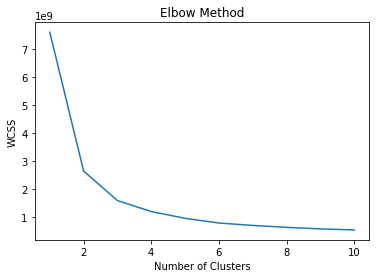

In [414]:
# Find the elbow.
wcss = []
for i in range(1, 11):
    kmeans_pre = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(pre)
    wcss.append(kmeans_pre.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

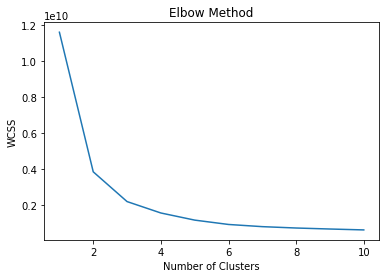

In [415]:
# Find the elbow.
wcss = []
for i in range(1, 11):
    kmeans_post = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(post)
    wcss.append(kmeans_post.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [416]:
# Initializes and fits KMeans model using PCA dimension reduced models.
kmeans_pre = KMeans(n_clusters=2, random_state=11).fit(pre_2_comp)
kmeans_post = KMeans(n_clusters=2, random_state=11).fit(post_2_comp)

In [417]:
# Adds cluster assignment column to original dataset.
cluster_labels = kmeans_pre.labels_
km_df_pre = df_pre.copy()
km_df_pre['Cluster'] = cluster_labels
km_df_pre['Player'] = np.array(pre_rule['Player'])

cluster_labels = kmeans_post.labels_
km_df_post = df_post.copy()
km_df_post['Cluster'] = cluster_labels
km_df_post['Player'] = np.array(post_rule['Player'])

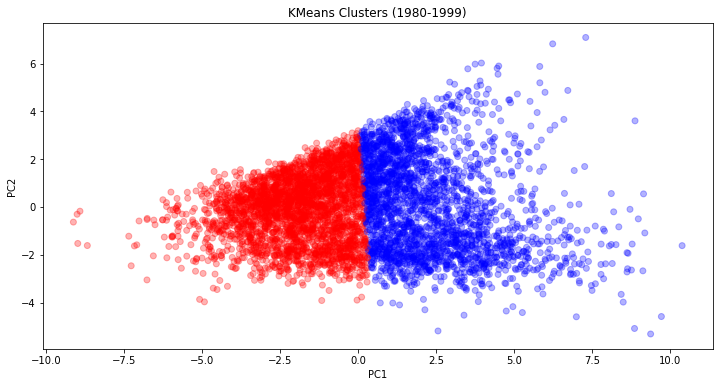

In [418]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {0:'red', 1:'blue'}

ax.scatter(km_df_pre['PC1'], km_df_pre['PC2'], c=km_df_pre['Cluster'].map(colors), alpha=0.3)

ax.set_title('KMeans Clusters (1980-1999)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

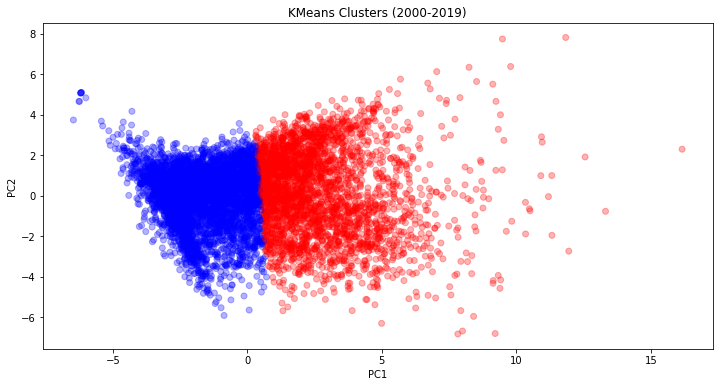

In [419]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {0:'red', 1:'blue'}

ax.scatter(km_df_post['PC1'], km_df_post['PC2'], c=km_df_post['Cluster'].map(colors), alpha=0.3)

ax.set_title('KMeans Clusters (2000-2019)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');